## Section 1: Importing of Libraries


In [1]:
#!/usr/bin/env python3
# ==================================================
# FULL PIPELINE: Human Motion Anomaly Detection
# ==================================================

# ---------------------------
# 1. Imports & Config
# ---------------------------
import os
import time
import copy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from torch.optim.lr_scheduler import ReduceLROnPlateau

## Section 2: Importation and Configuration of Dataset

In [2]:
# --- Configuration ---
BASE_DATA_DIR = r"C:\Thesis\Research"
SEQUENCE_LENGTH = 30
SEQUENCE_OVERLAP = 15
OUTLIER_THRESHOLD = 3.0
NUM_AUGMENTATIONS = 2
VALIDATION_SPLIT = 0.2

CENTRALIZED_EPOCHS = 30
CENTRALIZED_BATCH_SIZE = 64
CENTRALIZED_LR = 1e-3
EARLY_STOP_PATIENCE = 5

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------------------
# 2. Utilities
# ---------------------------
def set_seed(s: int):
    random.seed(s)
    np.random.seed(s)
    torch.manual_seed(s)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(s)

def model_size_and_params(model: nn.Module):
    num_params = sum(p.numel() for p in model.parameters())
    bytes_size = sum(p.numel() * 4 for p in model.parameters())  # float32
    return int(num_params), int(bytes_size)

## Section 3: Data Processing 

In [3]:
# ---------------------------
# 3. Data Discovery & Preprocessing
# ---------------------------
def find_skeleton_folders(base_dir: str):
    def list_subfolders(root, prefix_filter=None, exclude_contains=None):
        out = []
        if not os.path.exists(root):
            return out
        for d in sorted(os.listdir(root)):
            full = os.path.join(root, d)
            if os.path.isdir(full):
                if prefix_filter and not d.startswith(prefix_filter):
                    continue
                if exclude_contains and any(x in d for x in exclude_contains):
                    continue
                sk = os.path.join(full, 'skeletons')
                if os.path.exists(sk):
                    out.append(sk)
        return out

    return {
        'train_normal': list_subfolders(os.path.join(base_dir, 'train'), prefix_filter='N_', exclude_contains=['Curtain','Walk_Into_Room_and_Sit']),
        'test_normal': list_subfolders(os.path.join(base_dir, 'test'), prefix_filter='N_', exclude_contains=['Curtain','Walk_Into_Room_and_Sit']),
        'test_abnormal': list_subfolders(os.path.join(base_dir, 'test'), prefix_filter='ABN_', exclude_contains=['Curtain','Fall','Quick_Standing_Sitting']),
    }

def load_video_frames(folder_path: str):
    if not os.path.exists(folder_path):
        return np.array([])
    files = sorted([f for f in os.listdir(folder_path) if f.endswith('.npy')])
    frames = []
    for f in files:
        try:
            frames.append(np.load(os.path.join(folder_path, f)))
        except Exception:
            continue
    return np.stack(frames) if frames else np.array([])

def create_sequences(data: np.ndarray, seq_length: int, overlap: int):
    if data.size == 0 or len(data) < seq_length:
        return np.array([])
    step = seq_length - overlap
    seqs = [data[i:i+seq_length] for i in range(0, len(data) - seq_length + 1, step)]
    return np.array(seqs)

def augment_sequence(seq: np.ndarray):
    if seq.size == 0:
        return seq
    angle = np.random.uniform(-10, 10)
    th = np.radians(angle)
    R = np.array([[np.cos(th), -np.sin(th)], [np.sin(th), np.cos(th)]])
    out = seq.copy()
    if seq.ndim >= 3 and seq.shape[-1] >= 2:
        xy = seq[..., :2]
        center = xy.mean(axis=(0,1), keepdims=True)
        out[..., :2] = (xy - center) @ R.T + center
    out += np.random.normal(0, 0.005, out.shape)
    return out

def preprocess_skeleton(frames: np.ndarray, scaler: MinMaxScaler=None, fit_scaler=False, root_joint_index=0):
    if frames.size == 0:
        return np.array([]), scaler
    if frames.shape[1] > root_joint_index:
        root = frames[:, root_joint_index:root_joint_index+1, :]
        frames = frames - root
    flat = frames.reshape(len(frames), -1)
    mu = np.nanmean(flat, axis=0)
    sd = np.nanstd(flat, axis=0) + 1e-8
    z = np.abs((flat - mu) / sd)
    flat[z > OUTLIER_THRESHOLD] = np.nan
    # interpolate missing
    for i in range(flat.shape[1]):
        col = flat[:, i]
        nan = np.isnan(col)
        if nan.any():
            good = ~nan
            if good.any():
                col[nan] = np.interp(np.flatnonzero(nan), np.flatnonzero(good), col[good])
            else:
                col[:] = 0.0
    frames = flat.reshape(frames.shape)
    vel = np.gradient(frames, axis=0)
    feats = np.concatenate([frames, vel], axis=-1)
    if fit_scaler:
        scaler = MinMaxScaler(feature_range=(-1,1))
        scaler.fit(feats.reshape(-1, feats.shape[-1]))
    if scaler is not None:
        feats = scaler.transform(feats.reshape(-1, feats.shape[-1])).reshape(feats.shape)
    return feats, scaler

def process_folders_with_stats(folder_list, seq_len, overlap, scaler=None, fit_scaler=False, augmentations=0):
    all_seqs, stats, is_first = [], [], True
    for f in folder_list:
        frames = load_video_frames(f)
        if frames.size == 0:
            stats.append({'video': f, 'frames': 0, 'sequences': 0})
            continue
        proc, scaler = preprocess_skeleton(frames, scaler, fit_scaler and is_first)
        if is_first and fit_scaler:
            is_first = False
        seqs = create_sequences(proc, seq_len, overlap)
        count = 0
        if seqs.size > 0:
            all_seqs.append(seqs)
            count += seqs.shape[0]
        if fit_scaler and augmentations > 0:
            for _ in range(augmentations):
                aug = augment_sequence(frames)
                proc_aug, _ = preprocess_skeleton(aug, scaler)
                seqs_aug = create_sequences(proc_aug, seq_len, overlap)
                if seqs_aug.size > 0:
                    all_seqs.append(seqs_aug)
                    count += seqs_aug.shape[0]
        stats.append({'video': f, 'frames': len(frames), 'sequences': count})
    arr = np.vstack(all_seqs) if all_seqs else np.array([])
    return arr, pd.DataFrame(stats), scaler

def load_and_preprocess_display(base_dir, seq_len, overlap, augmentations=0):
    folders = find_skeleton_folders(base_dir)
    print("\nFound folders summary:", {k: len(v) for k,v in folders.items()})
    train_seqs, train_stats, scaler = process_folders_with_stats(folders['train_normal'], seq_len, overlap, None, True, augmentations)
    test_norm_seqs, test_norm_stats, _ = process_folders_with_stats(folders['test_normal'], seq_len, overlap, scaler, False, 0)
    test_abn_seqs, test_abn_stats, _ = process_folders_with_stats(folders['test_abnormal'], seq_len, overlap, scaler, False, 0)

    idx = np.arange(train_seqs.shape[0])
    np.random.default_rng(42).shuffle(idx)
    n_val = int(VALIDATION_SPLIT * len(idx))
    val_idx, train_idx = idx[:n_val], idx[n_val:]
    train_set, val_set = train_seqs[train_idx], train_seqs[val_idx]

    return train_set, val_set, (test_norm_seqs, test_abn_seqs)


## Section 4: Model Defintion and Configuring the Parameters

In [ ]:
# ---------------------------
# 4. Model Definitions
# ---------------------------
class TransformerAE(nn.Module):
    def __init__(self, input_dim, d_model=256, nhead=8, num_layers=6, dropout=0.2):  # Transformer Autoencoder
        super().__init__()
        self.embed = nn.Linear(input_dim, d_model)
        self.pos_encoder = nn.Parameter(torch.zeros(1, SEQUENCE_LENGTH, d_model))
        enc_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True, dim_feedforward=d_model*4, dropout=dropout)
        self.transformer = nn.TransformerEncoder(enc_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(d_model, input_dim)

    def forward(self, x):
        b, t, j, f = x.shape
        flat = x.view(b, t, -1)
        emb = self.embed(flat) + self.pos_encoder.repeat(b, 1, 1)
        enc = self.transformer(emb)
        out = self.fc_out(enc).view(b, t, j, f)
        return out, enc.mean(dim=1)

class LSTMAE(nn.Module):
    def __init__(self, input_dim, hidden_dim=4, latent_dim=2, num_layers=1):  # LSTM
        super().__init__()
        self.encoder = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.to_latent = nn.Linear(hidden_dim, latent_dim)
        self.from_latent = nn.Linear(latent_dim, hidden_dim)
        self.decoder = nn.LSTM(hidden_dim, input_dim, num_layers=num_layers, batch_first=True)

    def forward(self, x):
        b, t, j, f = x.shape
        x_flat = x.view(b, t, -1)
        enc_out, _ = self.encoder(x_flat)
        last = enc_out[:, -1, :]
        z = self.to_latent(last)
        proj = self.from_latent(z).unsqueeze(1).repeat(1, t, 1)
        dec_out, _ = self.decoder(proj)
        return dec_out.view(b, t, j, f), z

class CNNAE(nn.Module):
    def __init__(self, input_dim, latent_dim=4, seq_len=30):  # CNN
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(input_dim, 8, 5, 2, 2), nn.ReLU(),
            nn.Conv1d(8, 16, 5, 2, 2), nn.ReLU(),
            nn.Conv1d(16, latent_dim, 3, 2, 1), nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(latent_dim, 16, 3, 2, 1, output_padding=1), nn.ReLU(),
            nn.ConvTranspose1d(16, 8, 5, 2, 2), nn.ReLU(),
            nn.ConvTranspose1d(8, input_dim, 5, 2, 2, output_padding=1),
        )

    def forward(self, x):
        b, t, j, f = x.shape
        flat = x.reshape(b, t, -1).transpose(1, 2)
        z = self.encoder(flat)
        out_t = self.decoder(z)
        out_flat = out_t.transpose(1, 2)
        return out_flat.reshape(b, t, j, f), z.mean(dim=2)

class NormalAE(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, latent_dim=16):  # Normal 
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, latent_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
        )

    def forward(self, x):
        flat = x.view(x.size(0), -1)
        z = self.encoder(flat)
        recon_flat = self.decoder(z)
        recon = recon_flat.view_as(x)
        return recon, z

## Section 5: Reconstruction Losses & Evaluation


In [5]:
# ---------------------------
# 5. Losses & Evaluation
# ---------------------------
def choose_threshold(scores_val, y_val):
    best_f1, best_thr = -1.0, 0.0
    for thr in np.percentile(scores_val, np.linspace(0, 100, 200)):
        preds = (scores_val >= thr).astype(int)
        f1 = f1_score(y_val, preds, zero_division=0)
        if f1 > best_f1:
            best_f1, best_thr = f1, thr
    return best_thr, best_f1

def compute_errors_for_model(model, data, batch_size=128):
    if data.size == 0:
        return np.array([])
    loader = DataLoader(TensorDataset(torch.from_numpy(data).float()), batch_size=batch_size)
    errs = []
    model.eval()
    with torch.no_grad():
        for b in loader:
            x = b[0].to(DEVICE)
            recon, _ = model(x)
            mse = torch.mean((recon - x)**2, dim=tuple(range(1, x.ndim)))
            errs.append(mse.cpu().numpy())
    return np.concatenate(errs) if errs else np.array([])

def compute_scores_and_metrics(model, val_normal, test_normal, test_abnormal):
    val_norm = compute_errors_for_model(model, val_normal)
    val_abn = compute_errors_for_model(model, test_abnormal[:len(val_normal)])
    y_val = np.concatenate([np.zeros_like(val_norm), np.ones_like(val_abn)])
    thr, _ = choose_threshold(np.concatenate([val_norm, val_abn]), y_val)
    test_norm_errs, test_abn_errs = compute_errors_for_model(model, test_normal), compute_errors_for_model(model, test_abnormal)
    y_test = np.concatenate([np.zeros_like(test_norm_errs), np.ones_like(test_abn_errs)])
    test_scores = np.concatenate([test_norm_errs, test_abn_errs])
    auroc = roc_auc_score(y_test, test_scores)
    preds = (test_scores >= thr).astype(int)
    cm = confusion_matrix(y_test, preds, labels=[0, 1])
    return {'auroc': auroc, 'thr': thr, 'confusion': {'tn': int(cm[0, 0]), 'fp': int(cm[0, 1]), 'fn': int(cm[1, 0]), 'tp': int(cm[1, 1])},
            'mse_norm': float(np.mean(test_norm_errs)), 'mse_abn': float(np.mean(test_abn_errs)),
            'rmse_norm': float(np.sqrt(np.mean(test_norm_errs))), 'rmse_abn': float(np.sqrt(np.mean(test_abn_errs)))}, test_norm_errs, test_abn_errs


## Section 6: Routine for Training and Validation Processes

In [7]:
# ---------------------------
# 6. Training Routine
# ---------------------------
def centralized_train(model, train_data, val_data, epochs, batch_size, lr):
    model = copy.deepcopy(model).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
    loader = DataLoader(TensorDataset(torch.from_numpy(train_data).float()), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(torch.from_numpy(val_data).float()), batch_size=batch_size)
    loss_history, start = [], time.time()
    best_val_loss = float('inf')
    patience_counter = 0

    for ep in range(epochs):
        model.train()
        for batch in loader:
            x = batch[0].to(DEVICE)
            optimizer.zero_grad()
            recon, _ = model(x)
            loss = nn.functional.mse_loss(recon, x)
            loss.backward()
            optimizer.step()

        # Validation step
        model.eval()
        val_loss_sum = 0
        with torch.no_grad():
            for batch in val_loader:
                x = batch[0].to(DEVICE)
                recon, _ = model(x)
                val_loss_sum += nn.functional.mse_loss(recon, x, reduction='sum').item()
        val_loss = val_loss_sum / len(val_data)
        loss_history.append(val_loss)

        # Learning rate scheduler step
        scheduler.step(val_loss)

        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = copy.deepcopy(model.state_dict())
        else:
            patience_counter += 1
            if patience_counter >= EARLY_STOP_PATIENCE:
                print(f"Early stopping at epoch {ep+1}")
                model.load_state_dict(best_model_state)
                break

    total_time = time.time() - start
    return model, total_time, loss_history

## Section 7: Full Pipeline Implementation

In [8]:
# ---------------------------
# 7. Experiment Orchestration
# ---------------------------
def run_full_pipeline(base_dir=BASE_DATA_DIR):
    train_set, val_set, (test_norm, test_abn) = load_and_preprocess_display(base_dir, SEQUENCE_LENGTH, SEQUENCE_OVERLAP, NUM_AUGMENTATIONS)
    input_dim = train_set.shape[2] * train_set.shape[3]
    models = [
        ('Transformer', lambda: TransformerAE(input_dim)),  # Transformer first
        ('LSTM', lambda: LSTMAE(input_dim)),
        ('CNN', lambda: CNNAE(input_dim, seq_len=SEQUENCE_LENGTH)),
        ('Normal', lambda: NormalAE(SEQUENCE_LENGTH * input_dim))
    ]
    results = []
    set_seed(42)
    for name, build in models:
        print(f"\n--- Training {name} ---")
        model = build()
        trained, ctime, losses = centralized_train(model, train_set, val_set, CENTRALIZED_EPOCHS, CENTRALIZED_BATCH_SIZE, CENTRALIZED_LR)
        metrics, test_norm_errs, test_abn_errs = compute_scores_and_metrics(trained, val_set, test_norm, test_abn)
        nparams, nbytes = model_size_and_params(trained)
        results.append({'model': name, **metrics, 'training_time': ctime, 'num_params': nparams, 'model_size_MB': nbytes/(1024**2), 'loss_history': losses, 'test_norm_errs': test_norm_errs, 'test_abn_errs': test_abn_errs})
        print(f"{name} - AUROC={metrics['auroc']:.4f}, Thr={metrics['thr']:.4f}, Confusion={metrics['confusion']}")
    df = pd.DataFrame(results)
    # df.to_csv(os.path.join(OUT_DIR, "data", "comparison_results.csv"), index=False)
    return df

## Section 8: Visualization Procedures

In [9]:
# ---------------------------
# 8. Visualization
# ---------------------------
def plot_confusion_matrix(cm_dict, title):
    mat = np.array([[cm_dict['tn'], cm_dict['fp']], [cm_dict['fn'], cm_dict['tp']]])
    plt.figure(figsize=(4, 3))
    sns.heatmap(mat, annot=True, fmt="d", cbar=False,
                xticklabels=['Pred Normal', 'Pred Abnormal'], yticklabels=['True Normal', 'True Abnormal'])
    plt.title(title)
    plt.tight_layout()
    plt.show()

def post_analysis_and_plots(results_df):
    if results_df.empty:
        return
    sns.set(style="whitegrid", palette="tab10")

    # Bar chart for AUROC
    plt.figure(figsize=(6, 5))
    sns.barplot(data=results_df, x='model', y='auroc')
    plt.title("AUROC by Model")
    plt.tight_layout()
    plt.show()

    # Bar chart for MSE
    plt.figure(figsize=(8, 5))
    df_mse = results_df[['model', 'mse_norm', 'mse_abn']].melt('model', var_name='Metric', value_name='MSE')
    sns.barplot(data=df_mse, x='model', y='MSE', hue='Metric')
    plt.title("MSE by Model")
    plt.tight_layout()
    plt.show()

    # Bar chart for RMSE
    plt.figure(figsize=(8, 5))
    df_rmse = results_df[['model', 'rmse_norm', 'rmse_abn']].melt('model', var_name='Metric', value_name='RMSE')
    sns.barplot(data=df_rmse, x='model', y='RMSE', hue='Metric')
    plt.title("RMSE by Model")
    plt.tight_layout()
    plt.show()

    # Reconstruction Error Plots
    for idx, row in results_df.iterrows():
        plt.figure(figsize=(8, 5))
        sns.histplot(row['test_norm_errs'], color='skyblue', label='Normal', kde=True, stat='density', common_norm=False)
        sns.histplot(row['test_abn_errs'], color='red', label='Abnormal', kde=True, stat='density', common_norm=False)
        plt.axvline(x=row['thr'], color='green', linestyle='--', label='Threshold')
        plt.title(f"Reconstruction Error Distribution - {row['model']}")
        plt.xlabel("Reconstruction Error (MSE)")
        plt.legend()
        plt.tight_layout()
        plt.show()

    # Training Loss Graphs
    for idx, row in results_df.iterrows():
        plt.figure(figsize=(6, 4))
        plt.plot(range(1, len(row['loss_history']) + 1), row['loss_history'], marker='o')
        plt.title(f'Training Loss - {row["model"]}')
        plt.xlabel('Epoch')
        plt.ylabel('Validation Loss (MSE)')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # Confusion Matrix Heatmaps
    for idx, row in results_df.iterrows():
        mat = np.array([[row['confusion']['tn'], row['confusion']['fp']],
                        [row['confusion']['fn'], row['confusion']['tp']]])
        plt.figure(figsize=(4, 3))
        sns.heatmap(mat, annot=True, fmt="d", cbar=False,
                    xticklabels=['Pred Normal', 'Pred Abnormal'], yticklabels=['True Normal', 'True Abnormal'])
        plt.title(f'Confusion Matrix - {row["model"]}')
        plt.tight_layout()
        plt.show()

    # Final summary table
    print("\n=== Final Model Comparison for Anomaly Detection ===\n")
    summary_cols = ['model', 'auroc', 'mse_norm', 'mse_abn', 'rmse_norm', 'rmse_abn']
    print(results_df[summary_cols].to_string(index=False))
    print("\nHigher AUROC indicates better anomaly detection.")
    print("Higher MSE/RMSE on abnormal vs normal indicates better distinction.")
    print("The ideal model has high AUROC and a large difference between abnormal and normal reconstruction errors.")

## Section 9: Calling the Function to Run for all models


Found folders summary: {'train_normal': 7, 'test_normal': 7, 'test_abnormal': 8}

--- Training Transformer ---
Transformer - AUROC=0.9622, Thr=0.0094, Confusion={'tn': 59, 'fp': 31, 'fn': 0, 'tp': 75}

--- Training LSTM ---
LSTM - AUROC=0.9428, Thr=0.0285, Confusion={'tn': 78, 'fp': 12, 'fn': 5, 'tp': 70}

--- Training CNN ---
CNN - AUROC=0.9427, Thr=0.0213, Confusion={'tn': 74, 'fp': 16, 'fn': 3, 'tp': 72}

--- Training Normal ---
Normal - AUROC=0.9403, Thr=0.0152, Confusion={'tn': 51, 'fp': 39, 'fn': 1, 'tp': 74}


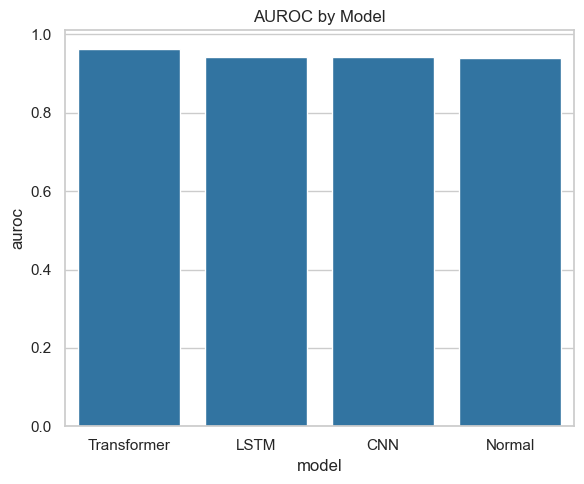

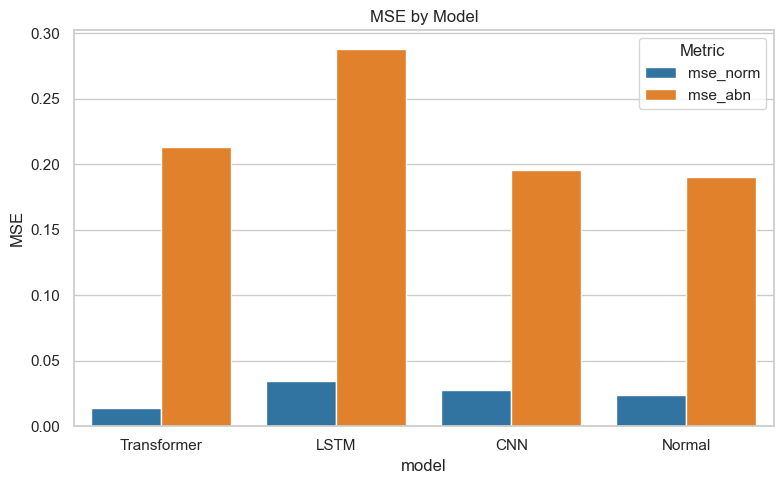

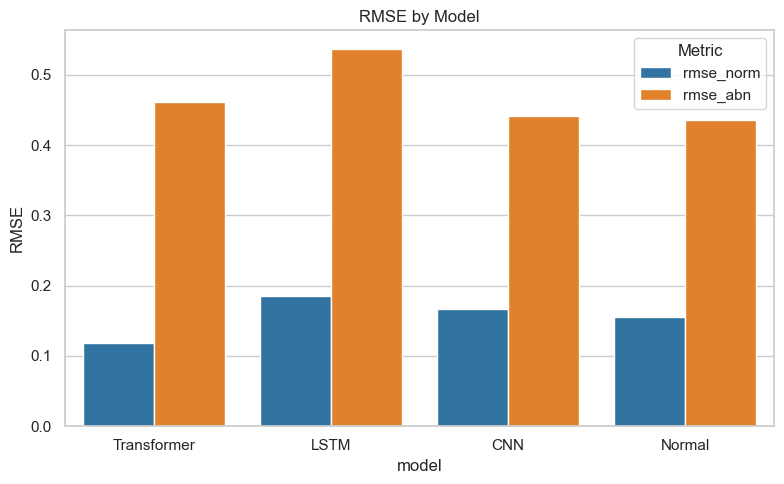

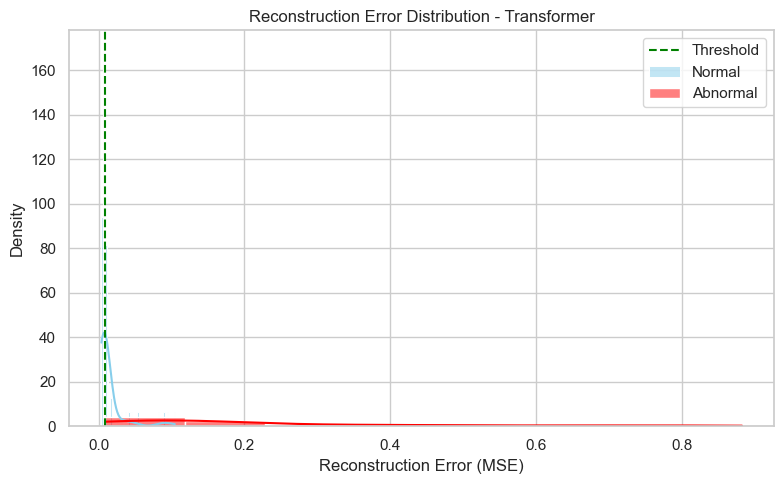

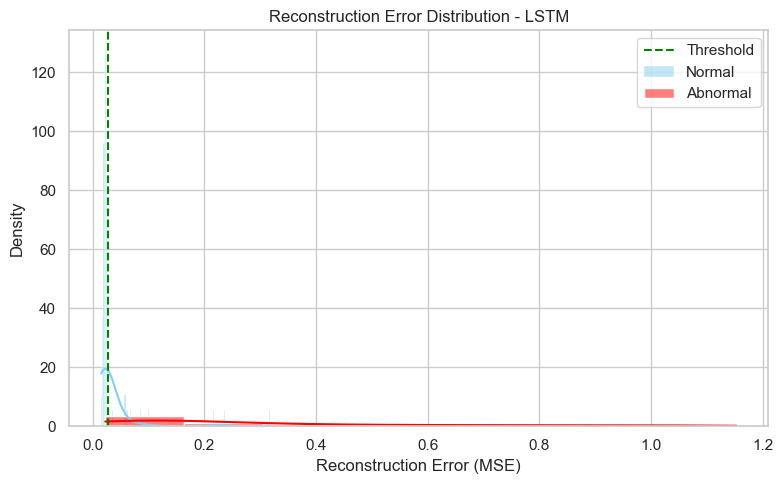

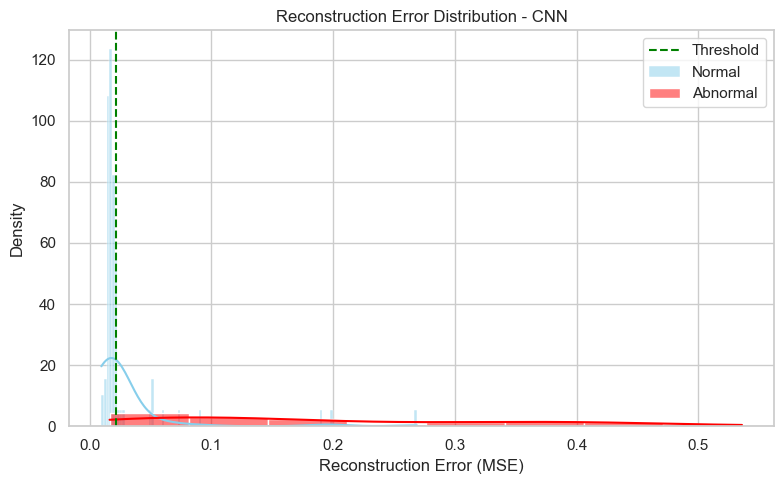

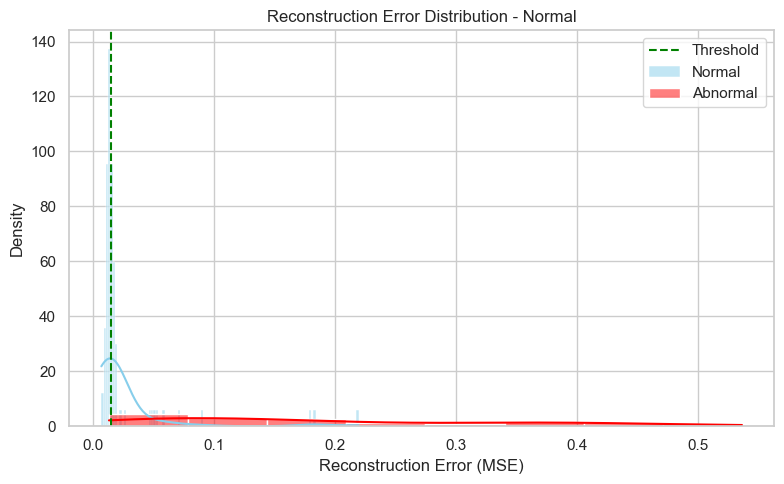

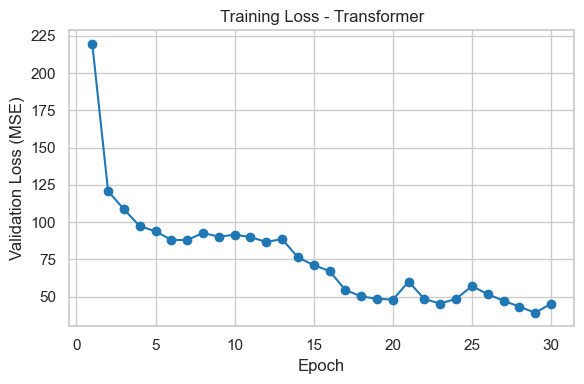

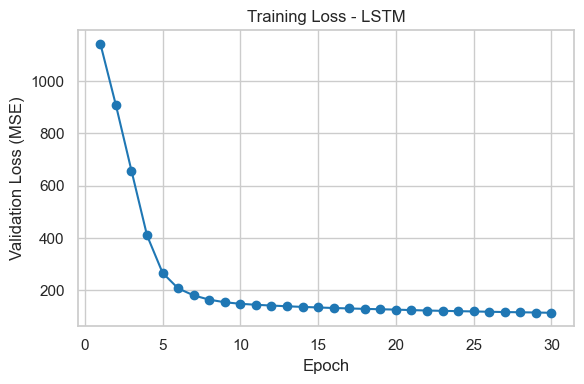

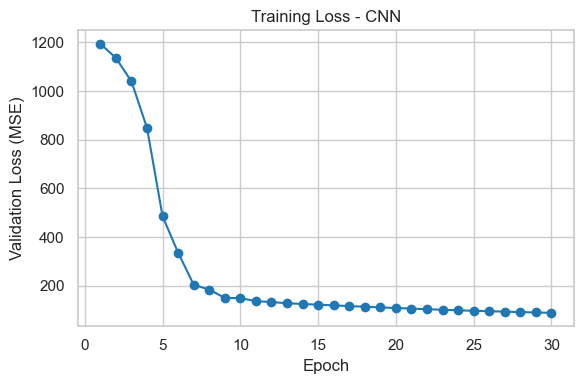

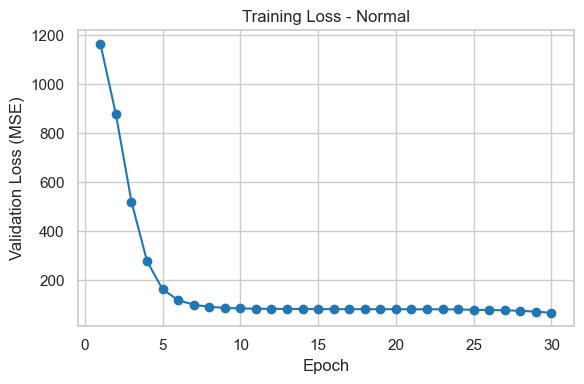

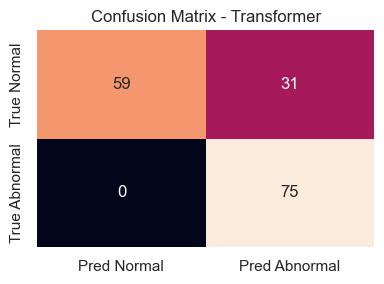

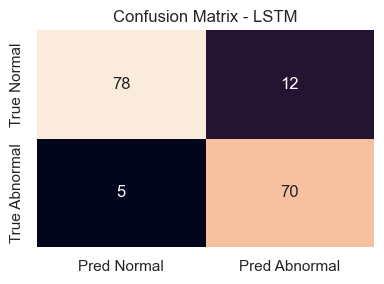

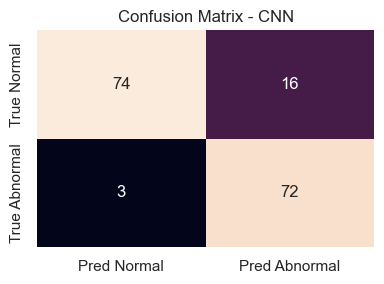

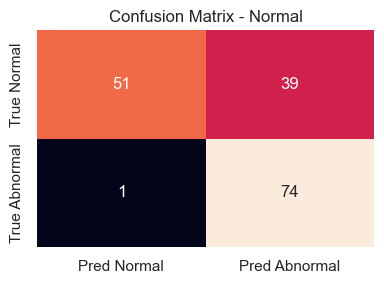


=== Final Model Comparison for Anomaly Detection ===

      model    auroc  mse_norm  mse_abn  rmse_norm  rmse_abn
Transformer 0.962222  0.013939 0.213591   0.118066  0.462159
       LSTM 0.942815  0.034419 0.287981   0.185523  0.536639
        CNN 0.942667  0.027800 0.195363   0.166734  0.441999
     Normal 0.940296  0.024000 0.190230   0.154921  0.436154

Higher AUROC indicates better anomaly detection.
Higher MSE/RMSE on abnormal vs normal indicates better distinction.
The ideal model has high AUROC and a large difference between abnormal and normal reconstruction errors.
Done. All results have been displayed.


In [10]:
# ---------------------------
# 9. Run
# ---------------------------
if __name__ == "__main__":
    results_df = run_full_pipeline()
    post_analysis_and_plots(results_df)
    print("Done. All results have been displayed.")